In [ ]:
import torch, torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from torchvision import datasets, transforms # This lets us easily download the Fashion MNIST dataset

# This emsures that our results are predictable
torch.manual_seed(0)
np.random.seed(0)

In [ ]:
# Hyperparameters
mini_batch_size = 128 # If None, batch gradient descent is done
n_epochs = 1 # Since our batch size is relatively small, adding more epochs will not help very much with accuracy

class_names = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]
# Targets in the dataset are represented by integers 0 - 9 corresponding to these classes

In [ ]:
# Loading the Fashion MNIST dataset
transform = transforms.Compose([
             transforms.Resize((28,28)),
             transforms.ToTensor(),
             transforms.Normalize((0,), (1,))
]) # Does normalization of data for us and ensures the data is in the correct shape and data type

train_set = datasets.FashionMNIST('.', train=True, download=True, transform=transform)
test_set = datasets.FashionMNIST('.', train=False, download=True, transform=transform)
# The data is downloaded only the 1st time

train_load = DataLoader(train_set, batch_size=mini_batch_size, shuffle=True)
test_load = DataLoader(test_set, batch_size=mini_batch_size, shuffle=True)
# Dataloaders split the data into mini batches. Here size is 128

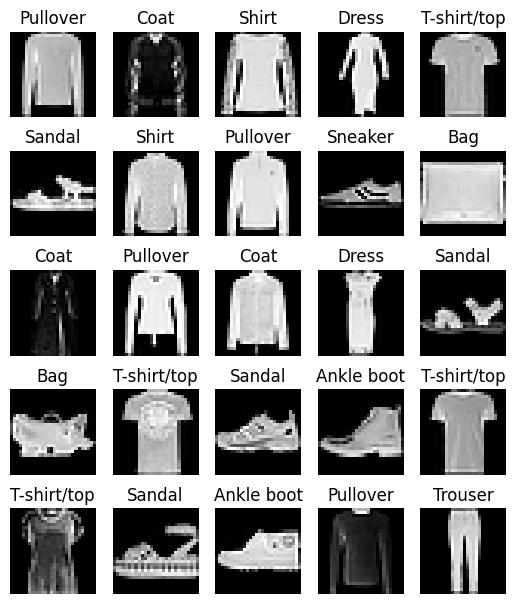

In [ ]:
train_images, train_labels = zip(*datasets.FashionMNIST('.', train=True, download=True))
# This is faster than using zip(*train_set)
train_images = np.asarray([np.array(img) for img in train_images], dtype=np.float32)
train_labels = np.asarray(train_labels, dtype=np.int64)
# A way to get your data in the form a numpy array

#Plotting random images from the data with matplotlib
img_indices = np.array([np.random.randint(0, len(train_images)) for i in range(25)]) # An array of random integers
fig, axes = plt.subplots(5, 5)
# A plot with 5 subplots
for n, i in enumerate(img_indices):
    axes[n//5, n%5].set_title(class_names[train_labels[i]])
    # // is integer division. This gets us the data in rows and columns of the graph
    img = train_images[i]
    axes[n//5, n%5].axis('off') # No need for z and y axes
    axes[n//5, n%5].imshow(img, cmap='gray') # Syntax for plotting images in numpy
plt.subplots_adjust(bottom=0, top=1.2) # Resizing

# **Defining the Network**

We use a network with 2 convolutional layers and 2 max pooling layers, stride of 1 and 3 x 3 kernels

### nn.Conv2d(in_channels, out_channels, kernel_size, stride = 1, padding = 0)
We're using grayscale images, so only 1 input channel is needed. For an RGB image, we would have 3 colours, so we would have 3 input channels.

Kernel size is the shape of the kernel. If it's square, we can use an integer like 3 or 5, if it's rectangular we can use a tuple like (3, 5).

Stride is 1 by default, so we don't need to define this.

Padding is 0 by default, so we use padding = 1 to preserve the size of the image

### nn.MaxPool2d(kernel_size, stride = None, padding = 0)
This takes in a kernel size (the size of each block). If we want a rectangel, a tuple eg. (2,3) can be used.

Stride defaults to the size of the kernel.

Padding is 0

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        nn.Module.__init__(self)
        self.convolutions = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),
            # 1 input image. If we had an RGB image, it would be Conv2d(3, 32, 3, padding=1)
            # 32 output images, i.e, 32 kernels and 32 output images are produced
            nn.ReLU(),
            # The activation function
            nn.MaxPool2d(2),
            # Pooling with 2 x 2 blocks
            nn.Conv2d(32, 64, 3, padding=1),
            # Now we have those 32 images and we make 64 from them
            nn.ReLU(),
            nn.MaxPool2d(2)
            # Pooling again
        )
        self.fully_connected = nn.Sequential(
            nn.Flatten(),
            nn.Linear((28*28*64)//16, 600),
            # The image shape was initially 28 x 28, by pooling we've made it 7 x 7, so we divide by 16
            # We multiply by 64 because the model has learnt 64 features.
            nn.Linear(600, 128),
            nn.Linear(128, 10)
            # We have 10 output neurons (1 for each class)
        )

    def forward(self, inputs):
        x = self.convolutions(inputs)
        # Functions in convolution layers are run
        x = self.fully_connected(x)
        # Functions in fully connected layer are run
        return x


class ANN(nn.Module):
    def __init__(self):
        nn.Module.__init__(self)
        self.stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 600),
            nn.ReLU(),
            nn.Linear(600, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
            nn.ReLU()
        )
        # This is an ordinary neural network for comparison

    def forward(self, inputs):
        x = self.stack(inputs)
        return x

cnn_model = CNN()
ann_model = ANN()

cnn_optimizer = torch.optim.Adam(cnn_model.parameters(), lr=2e-3)
ann_optimizer = torch.optim.Adam(ann_model.parameters(), lr=2e-3)
# Adam is being used as optimizer
loss_fn = nn.CrossEntropyLoss()
# Cross entropy is used for loss function

In [ ]:
# Defining one epoch of training
def train(model, train_loader=train_load, optimizer=cnn_optimizer, loss=loss_fn):
    # We train the appropriate model with the input data and the appropriate optimizer
    # ps is how often we print the accuracy
    train_iter = iter(train_load)
    model.train()
    # Puts model in train mode
    acc_hist = []
    for i, (data, targets) in enumerate(train_iter):
        # i is iteration, data = 1 mini batch of images, targets = 1 mini batch target values
        # This repeats for all mini batches
        outputs = model.forward(data) # Forward pass
        loss_val = loss(outputs, targets) # Loss computation
        optimizer.zero_grad()  # Ensures gradients stored in optimizer are reset before each backward pass
        loss_val.backward() # Backward pass
        optimizer.step() # Backward pass

        model.eval() # Getting the accuracy of the model into a list to plot it
        with torch.no_grad():
            predicted = outputs.max(1)[1]
            correct = (predicted == targets).sum().item()
            accuracy = correct/len(targets)
            acc_hist.append(accuracy*100)

    plt.ylim([0,100])
    plt.title('Model accuracy over time')
    plt.xlabel('Iteration')
    plt.ylabel('Accuracy')
    plt.hlines((40, 60, 80, 90), xmin=0, xmax=i+1, colors='r', linestyle='-') # Lines added for clarity
    plt.plot(acc_hist)


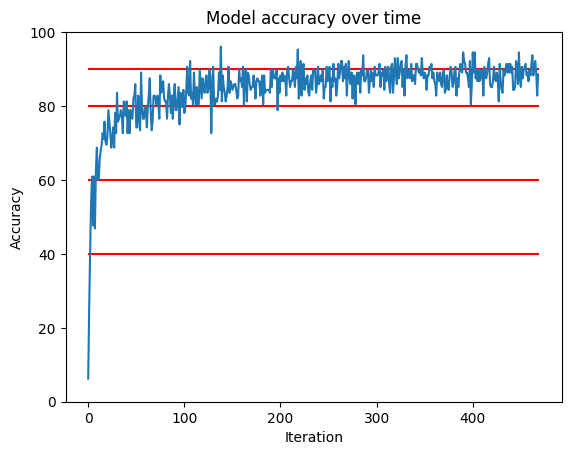

In [ ]:
for i in range(n_epochs):
  train(cnn_model)

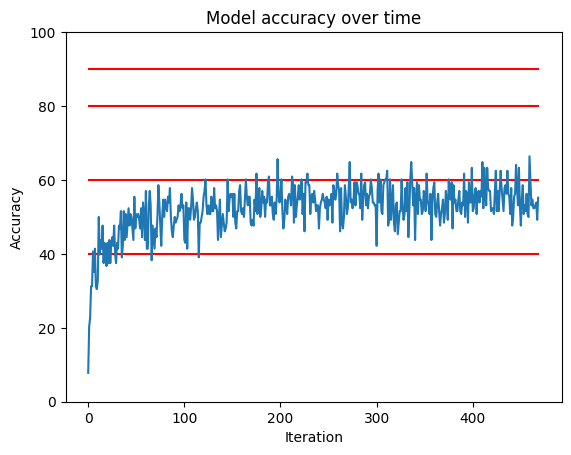

In [ ]:

for i in range(n_epochs):
  train(ann_model, optimizer = ann_optimizer)

In [ ]:
def accuracy(model, test):
    # Evaluate a model given a test loader
    model.eval()
    with torch.no_grad():
        count = 0
        correct = 0
        for data, targets in iter(test):
            outputs = model.forward(data)
            predicted = outputs.max(1)[1] # Maximum output is predicted class
            count += len(targets) # Total length of datasetS
            correct += (predicted == targets).sum().item()
            # This gives a tensor of True and False values and adds no. of True values to correct each iteration
        # print((predicted == targets).sum().item())
        accuracy = correct/count
        return accuracy

In [ ]:
cnn_acc_test = (accuracy(cnn_model, test_load))
cnn_acc_train = (accuracy(cnn_model, train_load))
print(
    f'''
    Accuracy on test dataset for CNN is {cnn_acc_test*100: .5f}%.
    Accuracy on train datset for CNN is {cnn_acc_train*100: .5f}%.
    '''
)
ann_acc_test = (accuracy(ann_model, test_load))
ann_acc_train = (accuracy(ann_model, train_load))
print(
    f'''
    Accuracy on test dataset for ANN is {ann_acc_test*100: .5f}%.
    Accuracy on train datset for ANN is {ann_acc_train*100: .5f}%.
    '''
)


    Accuracy on test dataset for CNN is  88.41000%.
    Accuracy on train datset for CNN is  89.94833%.
    

    Accuracy on test dataset for ANN is  53.63000%.
    Accuracy on train datset for ANN is  54.76000%.
    


In [ ]:
''' tensor([ True,  True,  True,  True,  True,  True, False,  True, False,  True,
         True,  True,  True,  True,  True, False,  True,  True,  True,  True,
         True, False,  True,  True,  True, False,  True, False,  True,  True,
         True,  True,  True, False,  True,  True,  True, False,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True, False,  True,
         True,  True, False,  True,  True,  True,  True,  True, False,  True,
         True,  True,  True,  True,  True,  True, False,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True, False,  True, False,
         True,  True,  True,  True,  True,  True, False, False,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
        False,  True,  True, False,  True, False,  True,  True]) '''
# Ouptut of predicted == targets

' tensor([ True,  True,  True,  True,  True,  True, False,  True, False,  True,\n         True,  True,  True,  True,  True, False,  True,  True,  True,  True,\n         True, False,  True,  True,  True, False,  True, False,  True,  True,\n         True,  True,  True, False,  True,  True,  True, False,  True,  True,\n         True,  True,  True,  True,  True,  True,  True,  True, False,  True,\n         True,  True, False,  True,  True,  True,  True,  True, False,  True,\n         True,  True,  True,  True,  True,  True, False,  True,  True,  True,\n         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,\n         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,\n         True,  True,  True,  True,  True,  True,  True, False,  True, False,\n         True,  True,  True,  True,  True,  True, False, False,  True,  True,\n         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,\n        False,  True,  True, False,  True, False, 